# Выбор локации для скважины

Проект для компании «ГлавРосГосНефть». В ходе исследования необходимо решить, где бурить новую скважину.

В качестве исходных данных предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:**

-	Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
-	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
-	Бюджет на разработку скважин в регионе — 10 млрд рублей.
-	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
-	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**План работы:**

Шаг 1.	Загрузите и подготовьте данные. Поясните порядок действий.

Шаг 2.	Обучите и проверьте модель для каждого региона:

- Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
- Обучите модель и сделайте предсказания на валидационной выборке.
- Сохраните предсказания и правильные ответы на валидационной выборке.
- Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
- Проанализируйте результаты.

Шаг 3.	Подготовьтесь к расчёту прибыли:

- Все ключевые значения для расчётов сохраните в отдельных переменных.
- Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 
- Напишите выводы по этапу подготовки расчёта прибыли.

Шаг 4.	Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

- Выберите скважины с максимальными значениями предсказаний. 
- Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитайте прибыль для полученного объёма сырья.

Шаг 5.	Посчитайте риски и прибыль для каждого региона:

- Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.



## Загрузка и подготовка данных

Для этой задачи заказчик предоставил данные с признаками:
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

Данные геологоразведки трёх регионов находятся в файлах: 
- /datasets/geo_data_0.csv. 
- /datasets/geo_data_1.csv. 
- /datasets/geo_data_2.csv. 



### Импортируем библиотеки

In [1]:
#!pip install phik -q
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from phik.report import plot_correlation_matrix
from phik import report


from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline
# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler, 
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer
# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import mean_squared_error

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from optuna.integration import OptunaSearchCV 

# загружаем нужные модели
from sklearn.linear_model import LinearRegression


### Загрузим данные. 

In [2]:
geo_data_0 = pd.read_csv('geo_data_0.csv', sep = ',')
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
geo_data_1 = pd.read_csv('geo_data_1.csv', sep = ',')
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
geo_data_2 = pd.read_csv('geo_data_2.csv', sep = ',')
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Предобработка данных.

#### Проверим наличие пропусков в данных.

In [5]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**В geo_data_0 пропусков нет.**

In [6]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**В geo_data_1 пропусков нет.**

In [7]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**В geo_data_2 пропусков нет.**

#### Проверим наличие дубликатов в данных.

In [8]:
print("Количество явных дубликатов в geo_data_0:", geo_data_0.duplicated().sum())
print("Количество явных дубликатов в geo_data_1:", geo_data_1.duplicated().sum())
print("Количество явных дубликатов в geo_data_2:", geo_data_2.duplicated().sum())

Количество явных дубликатов в geo_data_0: 0
Количество явных дубликатов в geo_data_1: 0
Количество явных дубликатов в geo_data_2: 0


#### Проверим, есть ли неявные дубликаты в столбцах типа object в train.

Проверим, есть ли строки, который совпадают по всем столбцам, кроме 'id'

In [9]:
print(geo_data_0.duplicated(subset=['f0','f1','f2'], keep=False).sum())
print(geo_data_1.duplicated(subset=['f0','f1','f2'], keep=False).sum())
print(geo_data_2.duplicated(subset=['f0','f1','f2'], keep=False).sum())

0
0
0


Таких строк нет.

Проверим, все ли 'id' уникальны.

In [10]:
print("Все значения в столбце 'id' уникальны:", geo_data_0['id'].is_unique)
print("Все значения в столбце 'id' уникальны:", geo_data_1['id'].is_unique)
print("Все значения в столбце 'id' уникальны:", geo_data_2['id'].is_unique)

Все значения в столбце 'id' уникальны: False
Все значения в столбце 'id' уникальны: False
Все значения в столбце 'id' уникальны: False


Выведем неуникальные 'id'

In [11]:
geo_data_0[geo_data_0.duplicated('id', keep=False)]

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


In [12]:
len(geo_data_0[geo_data_0.duplicated('id', keep=False)])

20

In [13]:
geo_data_1[geo_data_1.duplicated('id', keep=False)]

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [14]:
geo_data_2[geo_data_2.duplicated('id', keep=False)]

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Будем считать, что данные о скважинах с одинаковыми 'id' просто вводились в разное время, когда скважины были на разной стадии разработки. Оставим те строки, в которых максимальное значение 'product'.

In [15]:
geo_data_list = [geo_data_0, geo_data_1, geo_data_2]

for i in range(len(geo_data_list)):
    geo_data = geo_data_list[i]
    
    # находим дубликаты по столбцу 'id'
    duplicate_ids = geo_data[geo_data.duplicated('id', keep=False)]

    # находим максимальные значения 'product' для дублирующихся 'id'
    max_products = duplicate_ids.loc[duplicate_ids.groupby('id')['product'].idxmax()]
    unique_ids = geo_data[~geo_data['id'].isin(duplicate_ids['id'])]

    # объединяем уникальные id и максимальные значения product для дублирующихся id
    geo_data_combined = pd.concat([max_products, unique_ids]).reset_index(drop=True)
    geo_data_list[i] = geo_data_combined

    # выводим длину объединенного DataFrame
    print(f"Length of combined geo_data_{i}: {len(geo_data_combined)}")

geo_data_0, geo_data_1, geo_data_2 = geo_data_list

Length of combined geo_data_0: 99990
Length of combined geo_data_1: 99996
Length of combined geo_data_2: 99996


### Исследовательский анализ данных

**Проведем исследовательский анализ данных для geo_data_0.**

In [16]:
def hist_box(df,column):
    fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (18,8))
    sn.histplot(data = df,x = column, ax=axs[0], bins = 40, kde=True)
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('Количество')
    axs[0].set_title('Гистограмма')
    axs[0].grid(True) 
    sn.boxplot(data = df,x = column, ax=axs[1])
    axs[1].set_xlabel(column)
    axs[1].set_title('Диаграмма размаха')
    fig.suptitle(f'Гистограмма и диаграмма размаха для {column}')
    plt.show()
    print(df[column].describe())

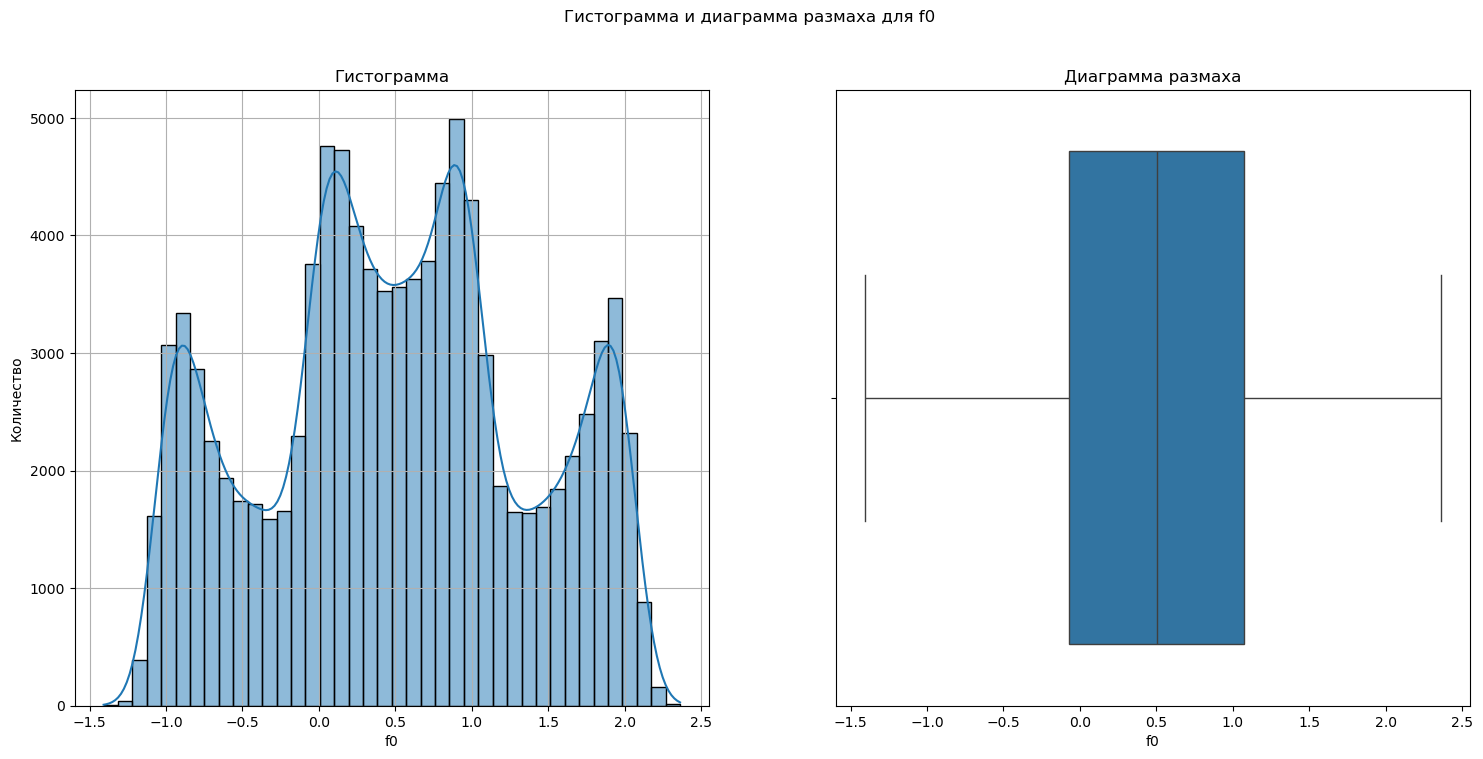

count    99990.000000
mean         0.500439
std          0.871857
min         -1.408605
25%         -0.072595
50%          0.502374
75%          1.073626
max          2.362331
Name: f0, dtype: float64


In [17]:
hist_box(geo_data_0,'f0')

На гистограмме признака f0 видны 4 пика, медиана равна 0.5  со стандартным отклонением 0.87. Выбросов нет

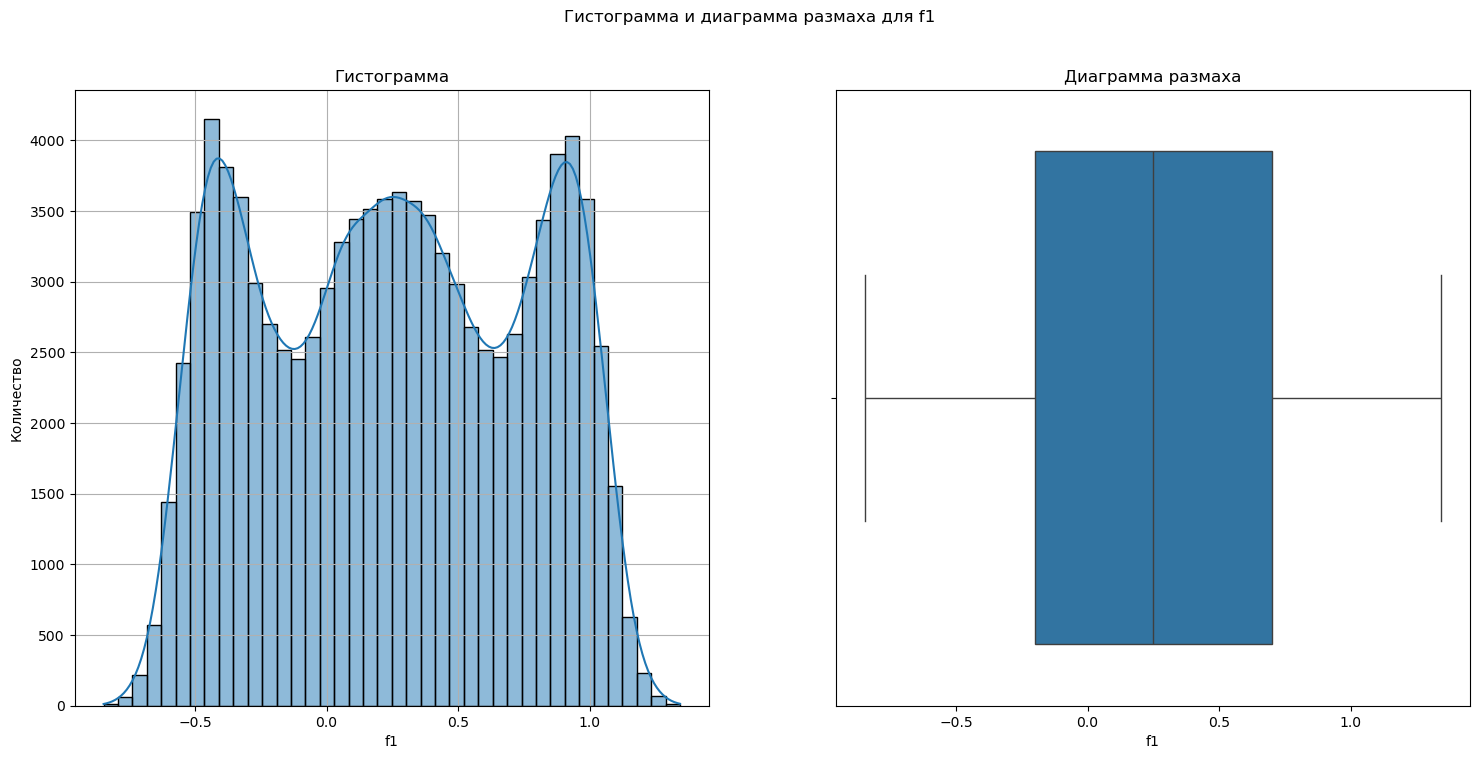

count    99990.000000
mean         0.250140
std          0.504433
min         -0.848218
25%         -0.200882
50%          0.250252
75%          0.700640
max          1.343769
Name: f1, dtype: float64


In [18]:
hist_box(geo_data_0,'f1')

На гистограмме признака f1 видны 3 пика, медиана равна 0.25  со стандартным отклонением 0.5. Выбросов нет.

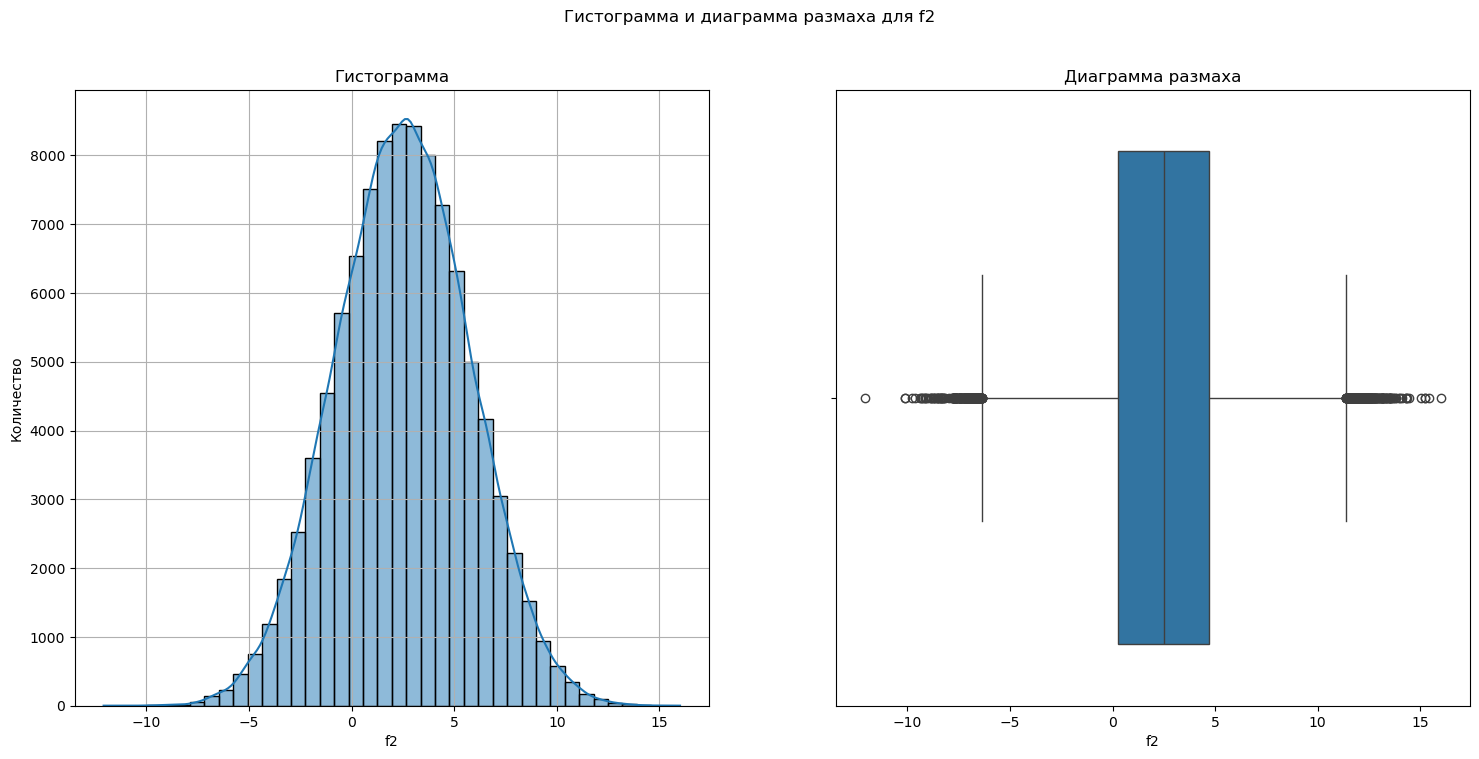

count    99990.000000
mean         2.502740
std          3.248177
min        -12.088328
25%          0.287887
50%          2.516005
75%          4.715035
max         16.003790
Name: f2, dtype: float64


In [19]:
hist_box(geo_data_0,'f2')

На гистограмме признака f2 виден 1 пик, медиана равна 2.52  со стандартным отклонением 3.24. На диаграмме размаха видны выбросы, но они не выглядят аномальными, оставим их.

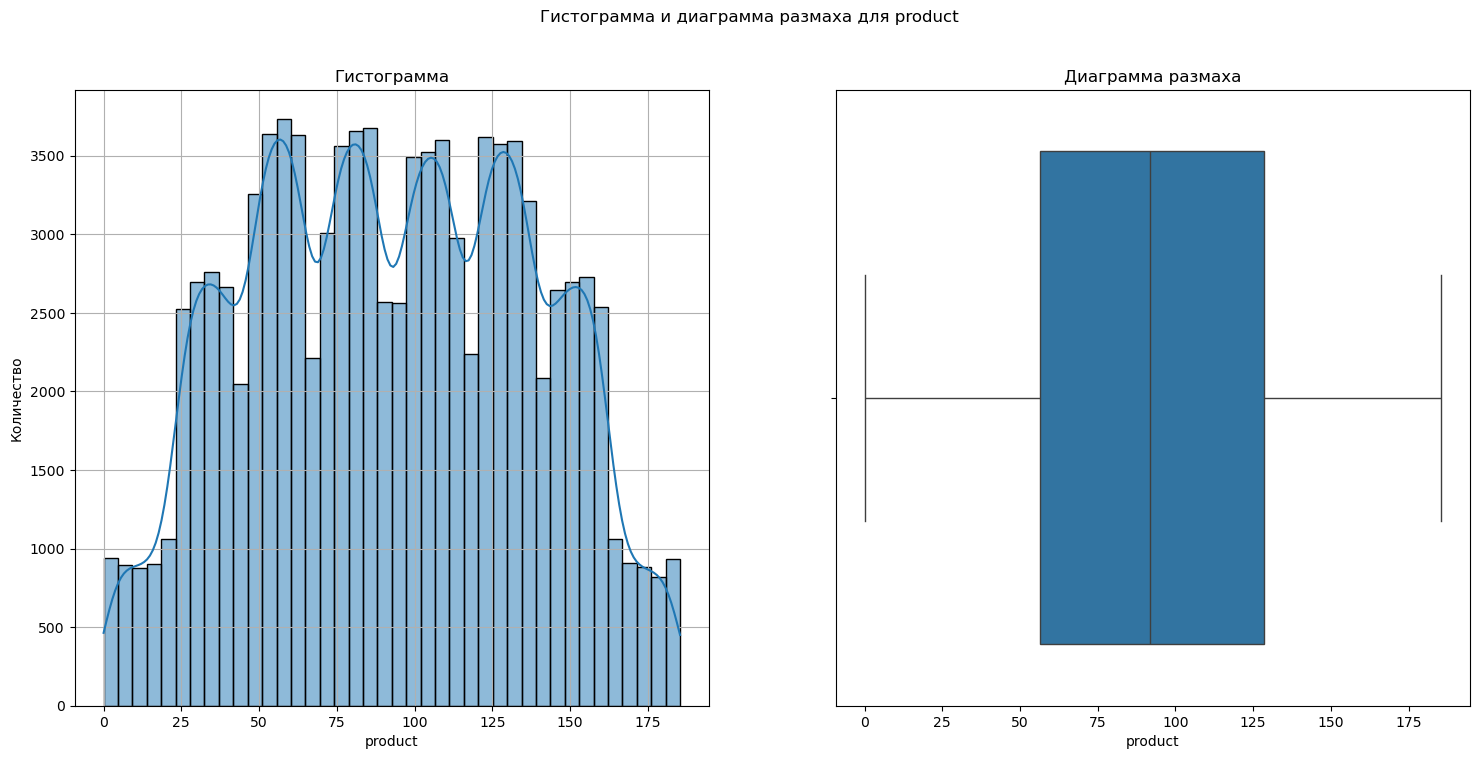

count    99990.000000
mean        92.501735
std         44.288557
min          0.000000
25%         56.497903
50%         91.853150
75%        128.564492
max        185.364347
Name: product, dtype: float64


In [20]:
hist_box(geo_data_0,'product')

На гистограмме целевого признака product видно 6 пиков, медиана равна 92  со стандартным отклонением 44, целевой признак принимает значения от 0 до 185.4. Медиана и среднее практически равны - это означает, что распределение данных симметрично.

Гистограмма с несколькими пиками указывает на наличие нескольких различных групп или кластеров данных в рассматриваемом наборе. 
Это может быть результатом смешивания нескольких распределений или указывать на неоднородность данных, что может быть важно для дальнейшего анализа или принятия решений.

**Проведем исследовательский анализ данных для geo_data_1.**

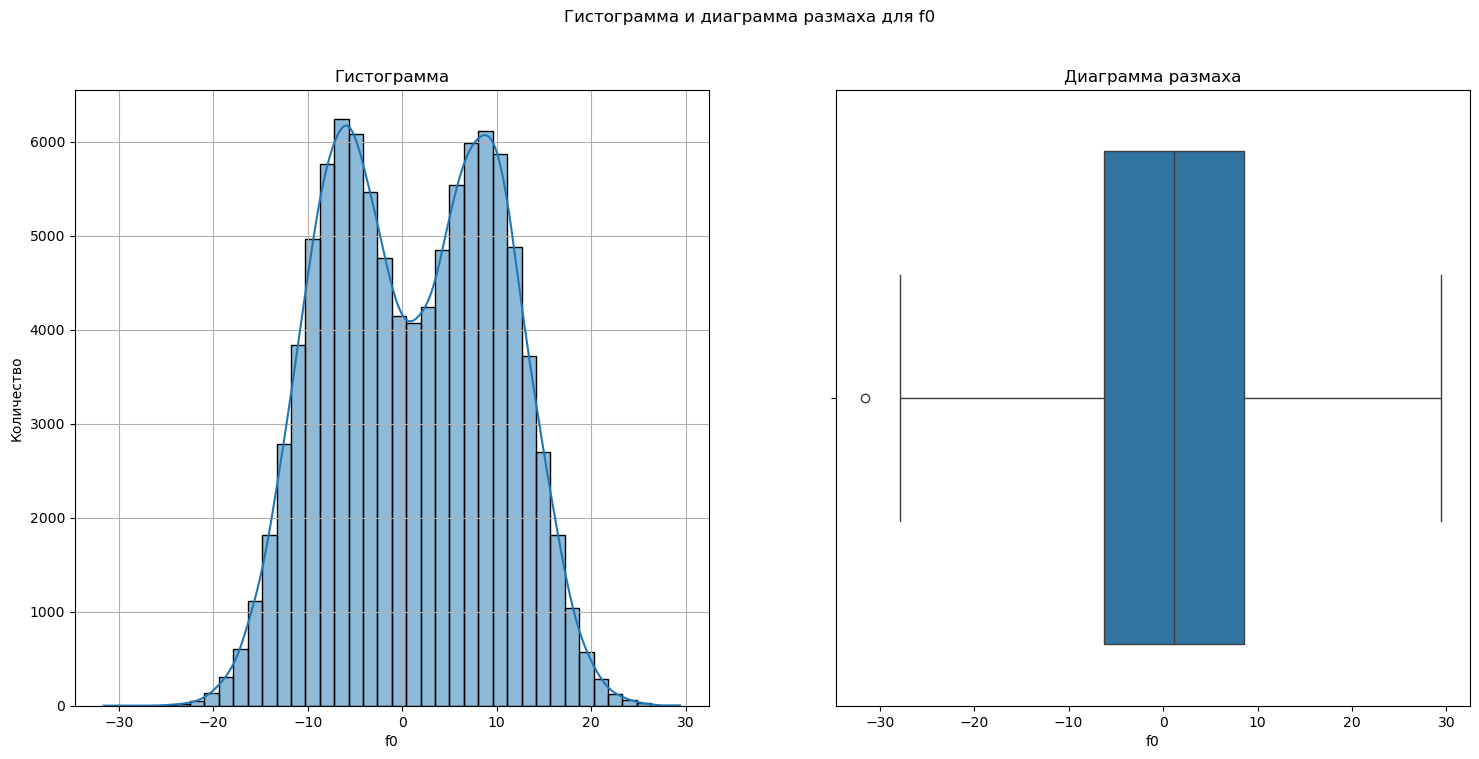

count    99996.000000
mean         1.141619
std          8.965953
min        -31.609576
25%         -6.298525
50%          1.153350
75%          8.621076
max         29.421755
Name: f0, dtype: float64


In [21]:
hist_box(geo_data_1,'f0')

На гистограмме 'f0' видно 2 пика, медиана равна 1.15 со стандартным отклонением 8.97, признак принимает значения от -31.6 до 29.4. Медиана и среднее практически равны - это означает, что распределение данных симметрично. Виден один выброс, он не выглядит аномальным, оставим его.

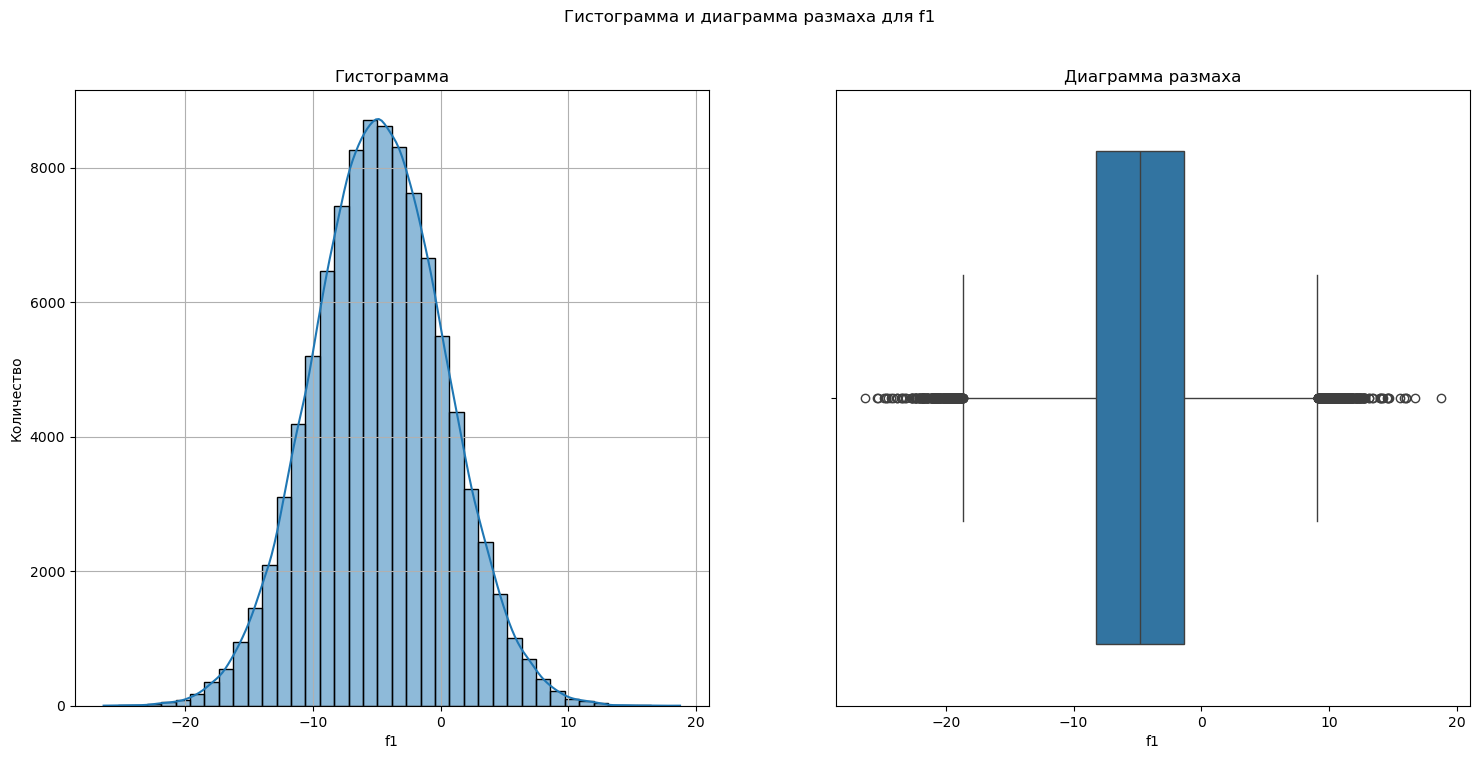

count    99996.000000
mean        -4.796476
std          5.119908
min        -26.358598
25%         -8.267985
50%         -4.813005
75%         -1.332704
max         18.734063
Name: f1, dtype: float64


In [22]:
hist_box(geo_data_1,'f1')

На гистограмме 'f1' виден 1 пик, медиана равна -4.8 со стандартным отклонением 5.1, признак принимает значения от -26.4 до 18.7. Медиана и среднее практически равны - это означает, что распределение данных симметрично. Видно несколько выбросов, но они не выглядят аномальными, оставим их.

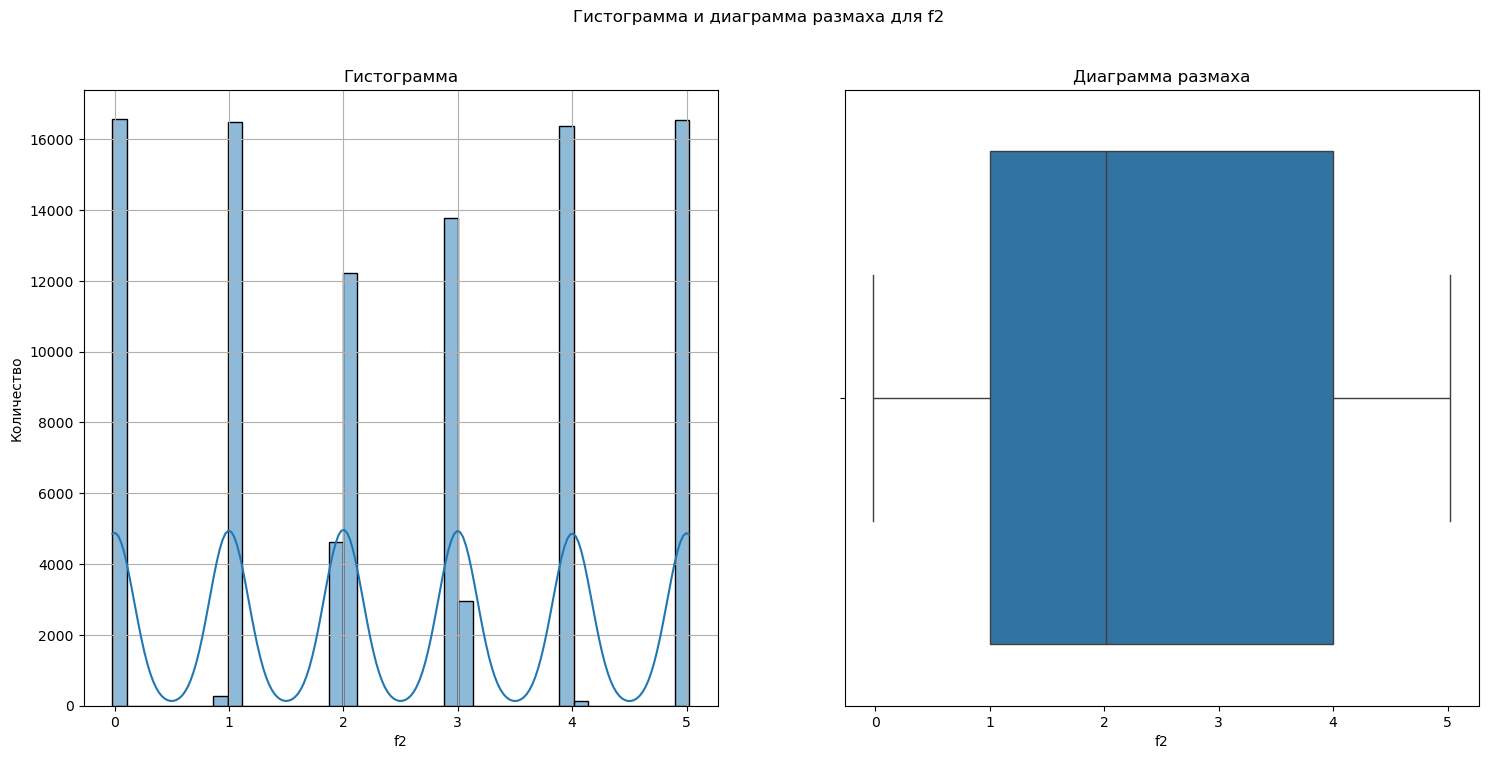

count    99996.000000
mean         2.494571
std          1.703585
min         -0.018144
25%          1.000021
50%          2.011480
75%          3.999904
max          5.019721
Name: f2, dtype: float64


In [23]:
hist_box(geo_data_1,'f2')

На гистограмме 'f2' видно, что данные имеют дискретное распределение, медиана равна 2 со стандартным отклонением 1.7, признак принимает значения от -0.02 до 5.02. Среднее значение 2.5 говорит о том, что в данных есть достаточно высокие значения, которые увеличивают среднее относительно медианы. Выбросов нет.

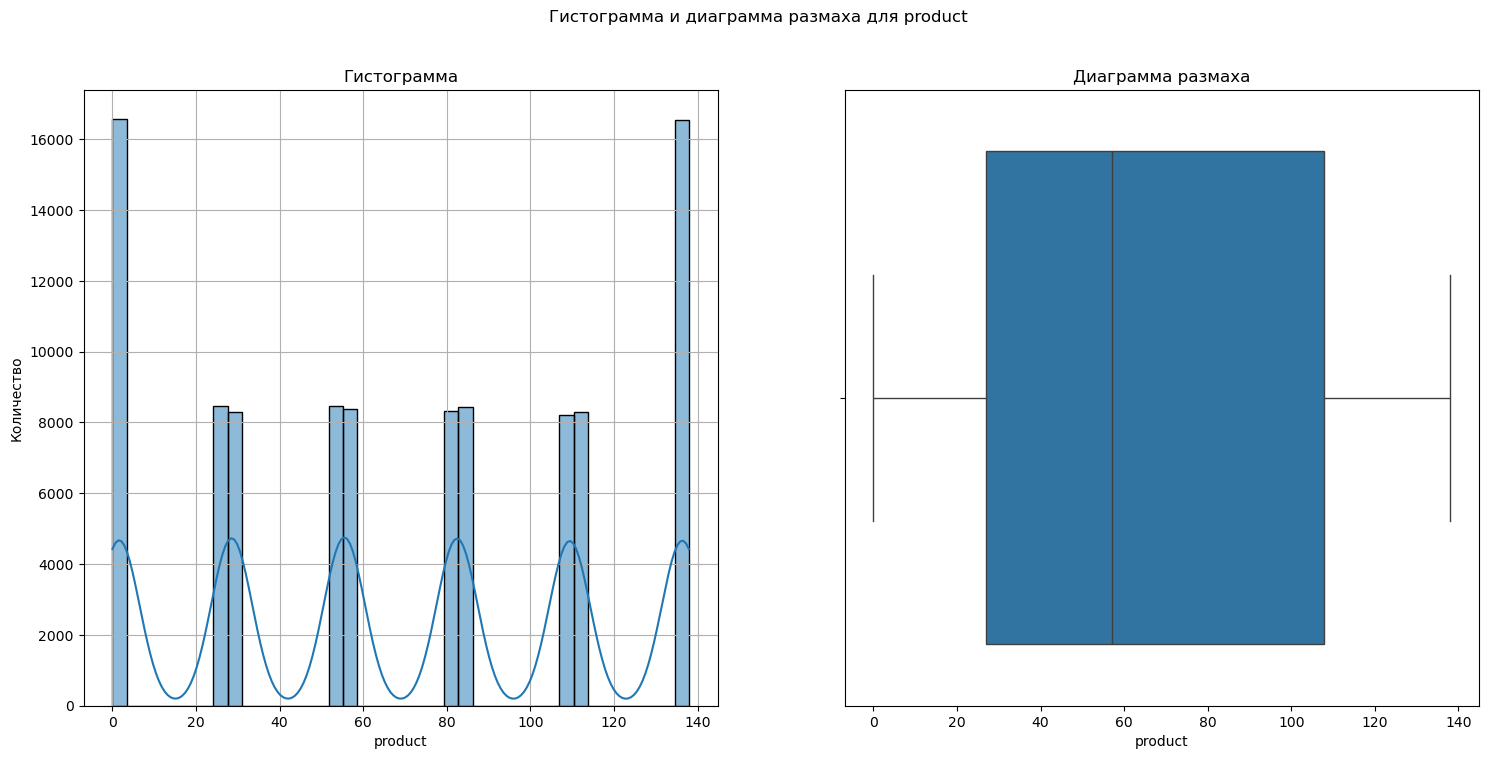

count    99996.000000
mean        68.825739
std         45.944818
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64


In [24]:
hist_box(geo_data_1,'product')

На гистограмме признака 'product' видно, что данные имеют дискретное распределение, медиана равна 57 со стандартным отклонением 46, целевой признак принимает значения от 0 до 138. Среднее значение 68.8 говорит о том, что в данных есть достаточно высокие значения, которые увеличивают среднее относительно медианы. Выбросов нет.

**Проведем исследовательский анализ данных для geo_data_2.**

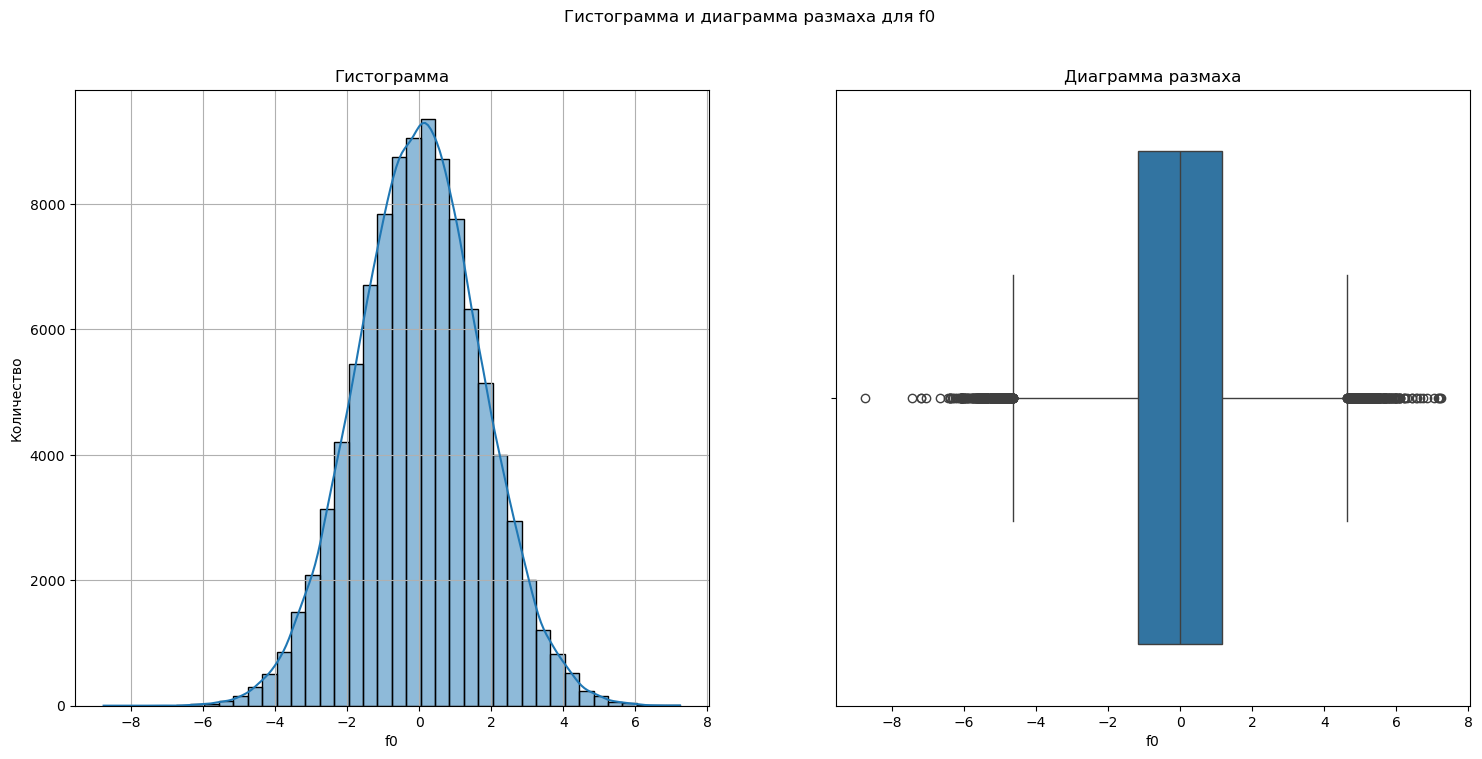

count    99996.000000
mean         0.001987
std          1.732050
min         -8.760004
25%         -1.162328
50%          0.009411
75%          1.158477
max          7.238262
Name: f0, dtype: float64


In [25]:
hist_box(geo_data_2,'f0')

На гистограмме признака 'f0' виден 1 пик, медиана равна 0 со стандартным отклонением 1.73, признак принимает значения от -8.76 до 7.24. Медиана и среднее практически равны - это означает, что распределение данных симметрично. Видно несколько выбросов, но они не выглядят аномальными, оставим их.

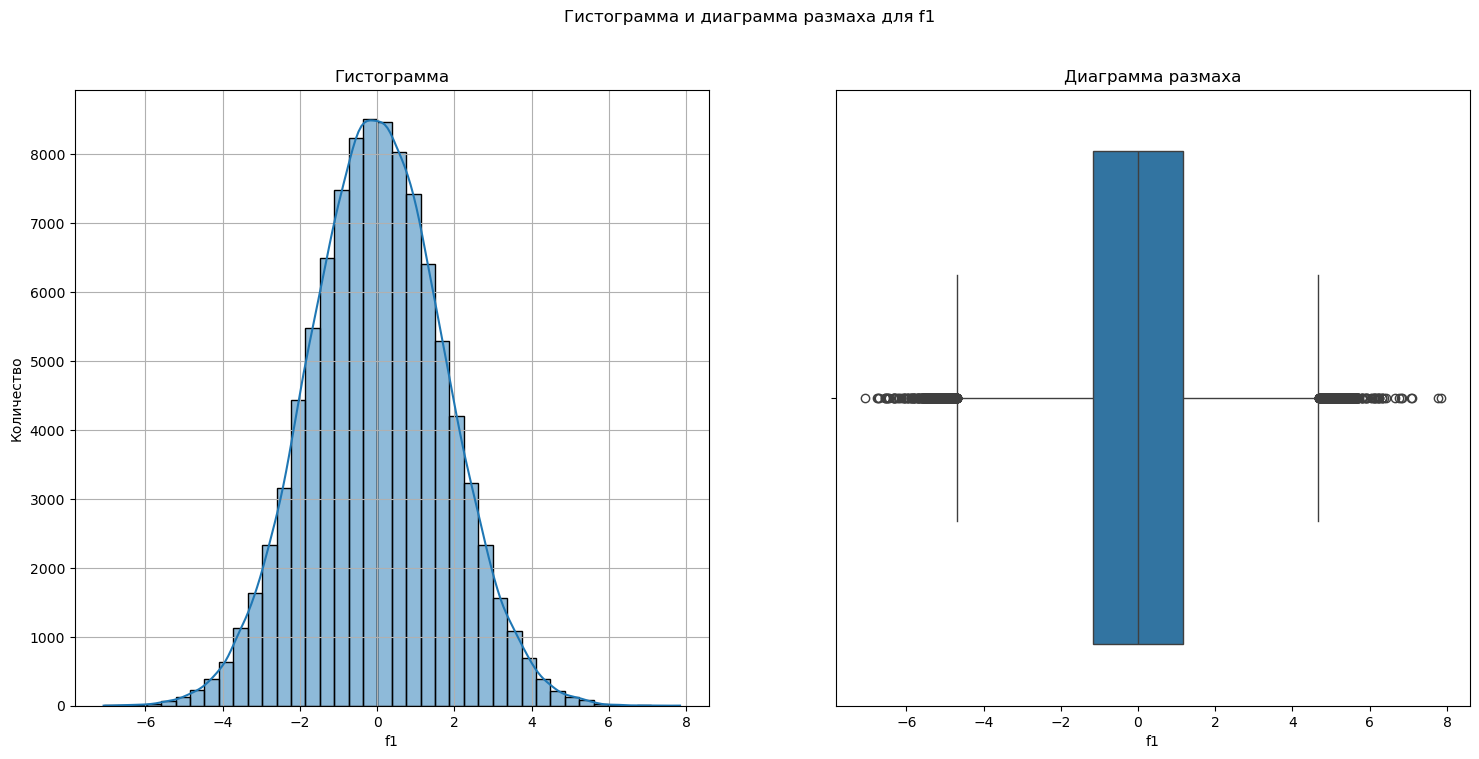

count    99996.000000
mean        -0.002093
std          1.730431
min         -7.084020
25%         -1.174820
50%         -0.009580
75%          1.163678
max          7.844801
Name: f1, dtype: float64


In [26]:
hist_box(geo_data_2,'f1')

На гистограмме признака 'f1' виден 1 пик, медиана равна 0 со стандартным отклонением 1.73, признак принимает значения от -7.1 до 7.84. Медиана и среднее практически равны - это означает, что распределение данных симметрично. Видно несколько выбросов, но они не выглядят аномальными, оставим их.

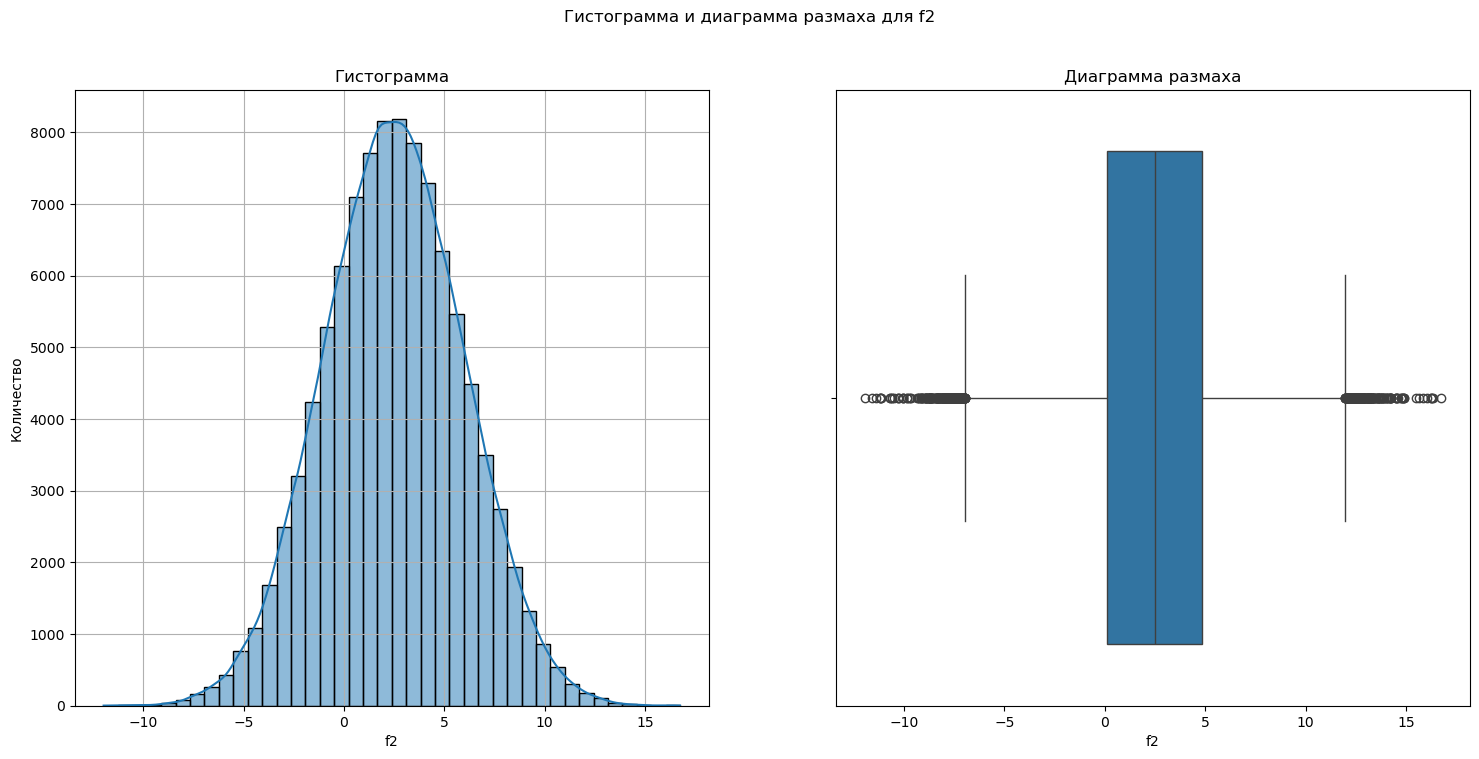

count    99996.000000
mean         2.495169
std          3.473466
min        -11.970335
25%          0.130359
50%          2.484256
75%          4.858794
max         16.739402
Name: f2, dtype: float64


In [27]:
hist_box(geo_data_2,'f2')

На гистограмме признака 'f2' виден 1 пик, медиана равна 2.5 со стандартным отклонением 3.47, признак принимает значения от -12 до 16.7. Медиана и среднее практически равны - это означает, что распределение данных симметрично. Видно несколько выбросов, но они не выглядят аномальными, оставим их.

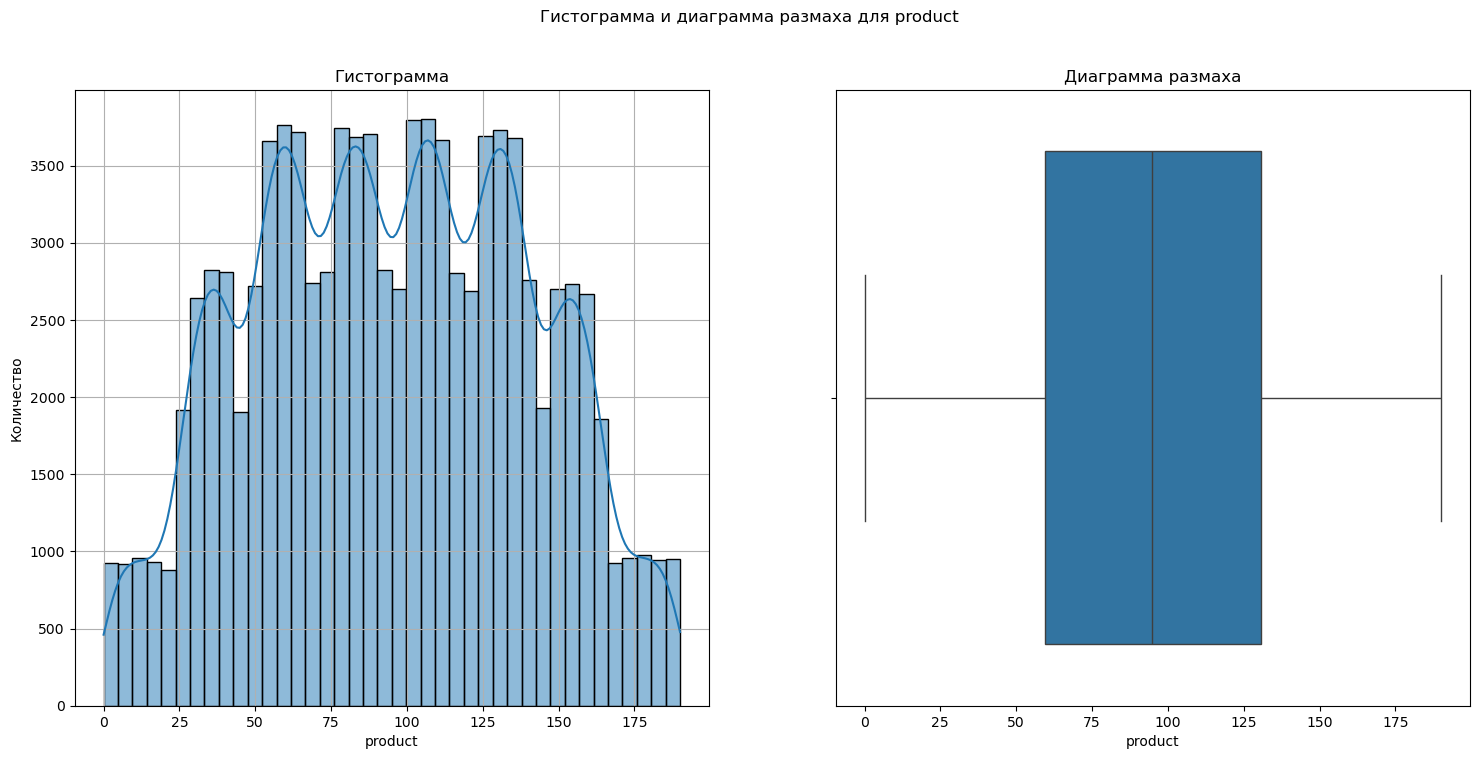

count    99996.000000
mean        95.001336
std         44.748968
min          0.000000
25%         59.452094
50%         94.925994
75%        130.595027
max        190.029838
Name: product, dtype: float64


In [28]:
hist_box(geo_data_2,'product')

На гистограмме признака 'product' присутствуют несколько пиков, медиана равна 95 со стандартным отклонением 45, признак принимает значения от 0 до 190. Медиана и среднее практически равны - это означает, что распределение данных симметрично. Выбросов нет.

Стандартное отклонение в 45 указывает на то, что данные имеют значительный разброс относительно среднего значения, то есть значения продукта могут значительно варьироваться, и присутствуют как низкие, так и высокие значения. Значения признака варьируются от 0 до 190. Это широкий диапазон, и наличие значений на обоих концах диапазона также может способствовать большому стандартному отклонению.


Гистограмма с несколькими пиками указывает на наличие нескольких различных групп или кластеров данных в рассматриваемом наборе, это может быть результатом смешивания нескольких распределений или указывать на неоднородность данных.

#### Корреляционный анализ данных

Проведем корреляционный анализ признаков. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.

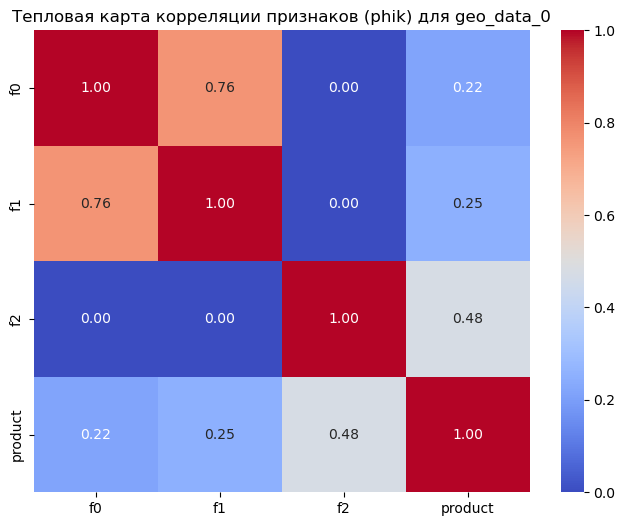

In [29]:
phik_corr = geo_data_0.drop(['id'], axis = 1).phik_matrix(interval_cols = ['f0', 'f1', 'f2', 'product']) 
plt.figure(figsize=(8, 6))
sn.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляции признаков (phik) для geo_data_0')
plt.show()

Между признаками наблюдается:


Сильная корреляция (значения выше 0.7):

* 0.76 - 'f1' и 'f0'


Умеренная корреляция (значения от 0.4 до 0.7):

* 0.48 - 'f2' и 'product'


Слабая корреляция или отсутствие корреляции для остальных признаков.

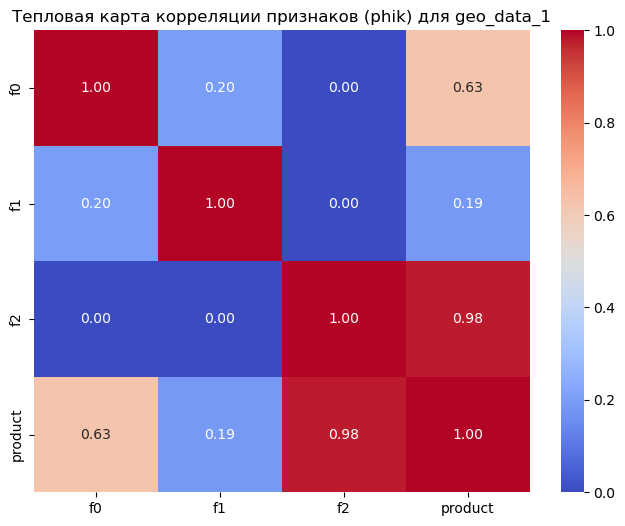

In [30]:
phik_corr = geo_data_1.drop(['id'], axis = 1).phik_matrix(interval_cols = ['f0', 'f1', 'f2', 'product']) 
plt.figure(figsize=(8, 6))
sn.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляции признаков (phik) для geo_data_1')
plt.show()

Между признаками наблюдается:


Сильная корреляция (значения выше 0.7):

* 0.98 - 'f2' и 'product'


Умеренная корреляция (значения от 0.4 до 0.7):
    
* 0.63 - 'f0' и 'product'


Слабая корреляция или отсутствие корреляции для остальных признаков.

Высокая корреляция вероятнее всего говорит здесь о действительно высокой корреляции, а не о мультиколлинеарности или утечке таргета. Скорее всего, особенность именно этого региона в том, что для него признак f2 сильно связан с выработкой продукта.

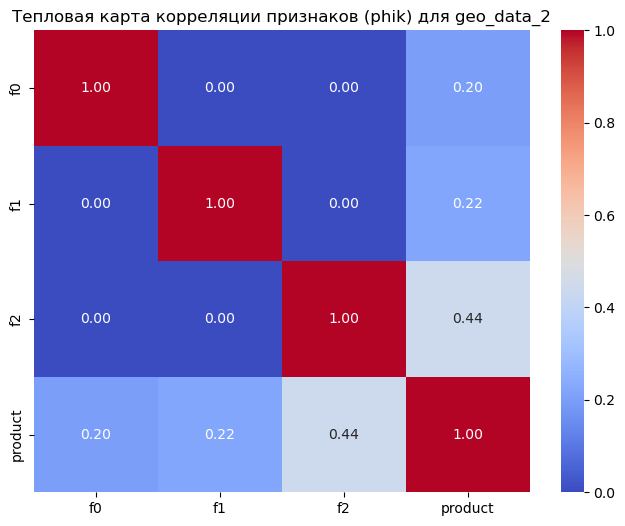

In [31]:
phik_corr = geo_data_2.drop(['id'], axis = 1).phik_matrix(interval_cols = ['f0', 'f1', 'f2', 'product']) 
plt.figure(figsize=(8, 6))
sn.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляции признаков (phik) для geo_data_2')
plt.show()

Между признаками наблюдается:


Умеренная корреляция (значения от 0.4 до 0.7):
    
* 0.44- 'f2' и 'product'


Слабая корреляция или отсутствие корреляции для остальных признаков.

**Вывод:** 

Данные загружены, предобработаны, пропусков нет, повторяющиеся 'id' обработаны: оставлены только 'id' с наибольшим значением 'product'.

geodata0:

• Признак f0: 4 пика, медиана 0.5, стандартное отклонение 0.87, выбросов нет.

• Признак f1: 3 пика, медиана 0.25, стандартное отклонение 0.5, выбросов нет.

• Признак f2: 1 пик, медиана 2.52, стандартное отклонение 3.24, есть выбросы, но не аномальные.

• Целевой признак product: 6 пиков, медиана 92, стандартное отклонение 44, выбросов нет, симметричное распределение.

geodata1:

• Признак f0: 2 пика, медиана 1.15, стандартное отклонение 8.97, один выброс (не аномальный).

• Признак f1: 1 пик, медиана -4.8, стандартное отклонение 5.1, несколько выбросов (не аномальные).

• Признак f2: дискретное распределение, медиана 2, стандартное отклонение 1.7, выбросов нет.

• Целевой признак product: дискретное распределение, медиана 57, стандартное отклонение 46, выбросов нет.

geodata2:

• Признак f0: 1 пик, медиана 0, стандартное отклонение 1.73, несколько выбросов (не аномальные).

• Признак f1: 1 пик, медиана 0, стандартное отклонение 1.73, несколько выбросов (не аномальные).

• Признак f2: 1 пик, медиана 2.5, стандартное отклонение 3.47, несколько выбросов (не аномальные).

• Целевой признак product: несколько пиков, медиана 95, стандартное отклонение 45, симметричное распределение, выбросов нет.

В целом, geodata0 и geodata2 имеют более сложные распределения с несколькими пиками для целевого признака и указывают на наличие различных групп в данных. Датафрейм geodata1 демонстрирует более простые распределения с меньшим количеством пиков и также содержит выбросы, которые не являются аномальными. Все наборы данных показывают симметричное распределение для ряда признаков и целевых значений, что может указывать на отсутствие значительных искажений в данных.


Проведен корреляционный анализ признаков.

Для geo_data_1 между признаками 'f2' и 'product' наблюдается очень сильная корреляция 0.98. Высокая корреляция вероятнее всего говорит здесь о действительно высокой корреляции, а не о мультиколлинеарности или утечке таргета. Скорее всего, особенность именно этого региона в том, что для него признак f2 сильно связан с выработкой продукта.

## Обучение и проверка модели

Установим 'id' в качестве индекса.

In [32]:
geo_data_0.set_index('id', inplace=True)
geo_data_1.set_index('id', inplace=True)
geo_data_2.set_index('id', inplace=True)

### Создадим модель

In [33]:
num_columns = ['f0', 'f1', 'f2']

In [34]:
data_preprocessor = ColumnTransformer(
    [ 
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [35]:
def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [36]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

### Сделаем предсказания и сохраним значения для каждого региона на валидационной выборке

**Предсказания для geo_data_0:**

Разобъем данные на обучающую и валидационную выборки 75:25.

In [37]:
RANDOM_STATE = 42

y = geo_data_0['product']
X = geo_data_0.drop(['product'], axis = 1)
X_train, X_val_0, y_train, y_val = train_test_split(
        X,
        y, 
        test_size=0.25, 
        random_state=RANDOM_STATE
)

In [38]:
pipe_final.fit(X_train, y_train)
y_pred_0 = pipe_final.predict(X_val_0)
y_val_0 = y_val

**Предсказания для geo_data_1:**

Разобъем данные на обучающую и валидационную выборки 75:25.

In [39]:
RANDOM_STATE = 42

y = geo_data_1['product']
X = geo_data_1.drop(['product'], axis = 1)
X_train, X_val_1, y_train, y_val = train_test_split(
        X,
        y, 
        test_size=0.25, 
        random_state=RANDOM_STATE
)

In [40]:
pipe_final.fit(X_train, y_train)
y_pred_1 = pipe_final.predict(X_val_1)
y_val_1 = y_val

**Предсказания для geo_data_2:**

Разобъем данные на обучающую и валидационную выборки 75:25.

In [41]:
RANDOM_STATE = 42

y = geo_data_2['product']
X = geo_data_2.drop(['product'], axis = 1)
X_train, X_val_2, y_train, y_val = train_test_split(
        X,
        y, 
        test_size=0.25, 
        random_state=RANDOM_STATE
)

In [42]:
pipe_final.fit(X_train, y_train)
y_pred_2 = pipe_final.predict(X_val_2)
y_val_2 = y_val

### Посчитаем средний запас предсказанного сырья и RMSE модели.

In [43]:
print('Средний запас предсказанного сырья для geo_data_0:', y_pred_0.mean().round(1))
print('RMSE модели для geo_data_0:', rmse_score(y_val_0,y_pred_0).round(1))

Средний запас предсказанного сырья для geo_data_0: 92.6
RMSE модели для geo_data_0: 37.6


In [44]:
print('Средний запас предсказанного сырья для geo_data_1:', y_pred_1.mean().round(1))
print('RMSE модели для geo_data_1:', rmse_score(y_val_1,y_pred_1).round(1))

Средний запас предсказанного сырья для geo_data_1: 68.7
RMSE модели для geo_data_1: 0.9


In [45]:
print('Средний запас предсказанного сырья для geo_data_2:', y_pred_2.mean().round(1))
print('RMSE модели для geo_data_0:', rmse_score(y_val_2,y_pred_2).round(1))

Средний запас предсказанного сырья для geo_data_2: 94.9
RMSE модели для geo_data_0: 40.0


### Анализ результата

**geo_data_0**: Средний запас предсказанного сырья составляет 92.6, а корень из средней квадратичной ошибки (RMSE) модели равен 37.6. 
RMSE показывает среднее отклонение предсказанных значений от фактических значений. Чем ниже значение RMSE, тем лучше модель подходит к данным. В нашем случае значение RMSE равно 37.6, что означает, что в среднем ваши предсказания отклоняются от реальных значений на 37.6 единиц. Целевой признак имеет разброс от 0 до 185.4. То есть, точность модели не очень высокая.

**geo_data_1**: Средний запас предсказанного сырья составляет 68.7, а корень из средней квадратичной ошибки (RMSE) модели равен 0.9. 
Таким образом, точность модели высокая.

**geo_data_2**: Средний запас предсказанного сырья составляет 94.9, а корень из средней квадратичной ошибки (RMSE) модели равен 40. 
Точность модели невысокая.

**Вывод:** 

• Регион 1: Несмотря на относительно высокий средний запас, модель предсказывает запасы с большой ошибкой (RMSE = 37.6). Это может указывать на наличие факторов, которые не были учтены в модели, или на высокую изменчивость данных.

  
• Регион 2: Модель показывает отличные результаты с очень низким RMSE, что говорит о том, что данные для этого региона более однородны или модель лучше захватывает закономерности.

• Регион 3: Имеет высокий средний запас, но также высокий RMSE (40.0), что может говорить о наличии сложных факторов или аномалий в данных.



Для первого и третьего регионов стоит рассмотреть возможность улучшения моделей, возможно, через добавление новых признаков, использование более сложных алгоритмов или методов отбора признаков.

  
Для второго региона можно проанализировать модель и данные более детально, чтобы понять, почему предсказания так точны и можно ли применить подобные подходы к другим регионам.

Возможно, стоит провести дополнительный анализ данных для всех регионов, чтобы выявить причины различий в средних запасах и точности предсказаний.


## Подготовка к расчёту прибыли

3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.

3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 

3.3. Напишите выводы по этапу подготовки расчёта прибыли.


### Ключевые значения для расчётов

Средний запас предсказанного сырья для geo_data_0, geo_data_1, geo_data_2 сохранены в переменных y_pred_0, y_pred_1, y_pred_2. Сохраним бюджет в отдельную переменную.

In [46]:
budget = 10000000000

### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

-	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
-	Бюджет на разработку скважин в регионе — 10 млрд рублей.
-	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
-	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Нам необходимо выбрать 200 точек, в которых суммарный объем продукта будет не менее 10 000 000 000 : 450 000. Это 22222,2 барреля.

Сравните полученный объём сырья со средним запасом в каждом регионе. В каждом регионе 10000 скважин, минимальный запас от 68 с небольшой RMSE, и запасами от 92.6 с высоким RMSE (до 40). 

### Выводы по этапу подготовки расчёта прибыли

Общий объем при среднем запасе в регионе geo_data_1:

200 × 68 = 13,600 баррелей

Это значение меньше необходимого объема (22,222.2 барреля).

Общий объем при среднем запасе в регионе geo_data_0:

200 × 92.6 = 18,520 баррелей

Это значение также меньше необходимого объема (22,222.2 барреля).



В обоих случаях объем сырья, получаемый из 200 точек со средним запасом, не достигает необходимого уровня в 22,222.2 барреля. Это означает, что выбранные точки не обеспечивают достаточный объем для разработки в рамках заданного бюджета.

Если вероятность убытков в регионах превышает 2.5%, то такие регионы также нужно исключить из рассмотрения.

Необходимо выбрать точки с максимальным прогнозируемым запасом, так как точки со средним запасом не смогут обеспечить достижение необходимого уровня объема сырья.



**Вывод:** Необходимые переменные были сохранены, был проанализирован необходимый объем добычи для безубыточности и сделан вывод о том, что необходимо выбрать точки с максимальным прогнозируемым запасом, так как точки со средним запасом не смогут обеспечить достижение необходимого уровня объема сырья.


## Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

**Выберем скважины с максимальными значениями предсказаний, просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям и рассчитаем прибыль.**

Сначала добавим столбец с предсказаниями к валидационной выборке для каждого региона

In [47]:
X_val_0['product_pred']=y_pred_0
X_val_0['product']=y_val_0

X_val_1['product_pred']=y_pred_1
X_val_1['product']=y_val_1

X_val_2['product_pred']=y_pred_2
X_val_2['product']=y_val_2

Выберем скважины с максимальными значениями предсказаний, просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.

In [48]:
def profit(X_val):
    produсе_pred = X_val.iloc[:, 2]

    # индексы 200 максимальных значений
    indices = np.argsort(produсе_pred)[-200:]

    top_200 = X_val.iloc[indices]

    #просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
    target_product=top_200['product'].sum()

    region_profit = target_product*450000 - budget
    return region_profit

Рассчитаем прибыль для полученного объёма сырья:

In [49]:
profit_region = [X_val_0, X_val_1, X_val_2]
names = ['profit_region_0', 'profit_region_1', 'profit_region_2']

for region, name in zip(profit_region, names):
    print(f'{name}: {profit(region)}')

profit_region_0: 2609387038.419142
profit_region_1: 2254859926.4878674
profit_region_2: 2497426931.9704895


**Вывод:** Была написана функция для расчета прибыли по выбранным скважинам и предсказаниям модели. Для каждого региона были полученны следующие значения прибыли при выборе лучших по предсказанному объему сырья скважин:

geo_data_0: 2.6 млрд

geo_data_1: 2.25 млрд

geo_data_2: 2.5 млрд

## Посчитайте риски и прибыль для каждого региона:

### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [50]:
state = np.random.RandomState(12345)

Напишем функцию для подсчета средней прибыли, 95%-й доверительного интервала и риска убытков.

In [51]:
def geo_stat(X_val):
    state = np.random.RandomState(12345)
    profit_region = []
    for i in range(1000):
        subsample = X_val.sample(n=500, replace = True, random_state=state)
        profit_region.append(profit(subsample))
    pd.Series(profit_region).mean()
    print('Средняя прибыль', pd.Series(profit_region).mean())
    # вычисляем 95%-й доверительный интервал
    profit_series = pd.Series(profit_region)  # Преобразуем в Series
    lower = profit_series.quantile(0.025).round()
    upper = profit_series.quantile(0.975).round()
    print(f'95%-й доверительный интервал: ({lower}, {upper})')

    # количество отрицательных значений
    negative_count = sum(1 for x in profit_region if x < 0)

    # Общее количество значений в выборке
    total_count = len(profit_region)

    # Вычисление вероятности
    probability_negative = negative_count / total_count *100

    print('Вероятность того, что значение будет отрицательным:', round(probability_negative, 2), '%')

### Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона

In [52]:
profit_region = [X_val_0, X_val_1, X_val_2]
names = ['geo_data_0', 'geo_data_1', 'geo_data_2']

for region, name in zip(profit_region, names):
    print(name)
    geo_stat_result = geo_stat(region)
    if geo_stat_result is not None:  # Проверяем, не является ли результат None
        print(geo_stat_result)

geo_data_0
Средняя прибыль 269210696.27751
95%-й доверительный интервал: (-193075873.0, 731114697.0)
Вероятность того, что значение будет отрицательным: 14.7 %
geo_data_1
Средняя прибыль 436162369.3218591
95%-й доверительный интервал: (35283760.0, 853009417.0)
Вероятность того, что значение будет отрицательным: 1.5 %
geo_data_2
Средняя прибыль 360472343.38350093
95%-й доверительный интервал: (-156370704.0, 925918260.0)
Вероятность того, что значение будет отрицательным: 9.9 %


Итак, были полученные следующие результаты:

**для geo_data_0:**

* Средняя прибыль  269210696.27751

* 95%-й доверительный интервал: (-193075873.0, 731114697.0)

* Вероятность того, что значение будет отрицательным: 14.7 %


**для geo_data_1:**

* Средняя прибыль 436162369.3218591

* 95%-й доверительный интервал: (35283760.0, 853009417.0)

* Вероятность того, что значение будет отрицательным: 1.5 %


**для geo_data_2:**

* Средняя прибыль 360472343.38350093

* 95%-й доверительный интервал: (-156370704.0, 925918260.0)

* Вероятность того, что значение будет отрицательным:  9.9 %



### Выводы: предложим регион для разработки скважин и обоснуем выбор.

На основе представленных данных, geodata1 является наиболее подходящим регионом для разработки скважин по следующим причинам:

* geodata1 имеет наивысшую среднюю прибыль (421004145.58), что говорит о большем потенциальном доходе от разработки в этом регионе.


* Вероятность того, что значение будет отрицательным, составляет всего 1.2%, что значительно ниже, чем в других регионах (12.1% для geodata0 и 10.4% для geodata2). Это говорит о меньших рисках при инвестициях в разработку. Кроме того, по условию, если вероятность убытков в регионах превышает 2.5%, то такие регионы также нужно исключить из рассмотрения, то есть ни один регион, кроме geo_data_1 не подходит.


* Доверительный интервал для geodata1 (40227092.0, 834438102.0) не включает отрицательные значения и имеет относительно широкий диапазон, что указывает на высокую степень уверенности в том, что прибыль будет положительной.


Таким образом, на основании анализа представленных данных, выбор региона geodata1 для разработки скважин представляется наиболее обоснованным и перспективным с точки зрения экономической выгоды и минимизации рисков.


**Вывод:** Была написана функция для нахождения средней прибыли, 95%-й доверительного интервала и риска убытков, для поиска средней прибыли была применена техника Bootstrap. Регион geo_data_1 оказался наиболее перспективен для разработки с точки зрения прибыльности.